 # Tutorial: DERController


 **This tutorial introduces the pandapower `DERController`**

 The `DERController` can be used to model Distributed Energy Resource (DER) capabilities for reactive power (Q) provision. The capabilities of reactive power provision may have differnent dependencies:
 + Q(P) capability: defines the reactive power capability depending on the DER active power generation
 + Q(V) capability: defines the reactive power capability depending on the voltage at the DER network connection point

 Different local control characteristics are included and can be applied via `DERController`, in particular:
 + const Q: fixed Q setpoint
 + fixed cosphi: fixed power factor
 + cosphi(P): power factor-watt function
 + Q(V): volt- var function
 + Voltage-Limitation function (in German Spannungsbegrenzungsfunktion)

 Common DER capabilities and local control characteristics are predefined in DERController according to German Grid Codes.

 **First of all we import all needed packages and libraries:**

In [1]:
# Importing necessary packages
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.control.controller.DERController as DERModels
from pandapower.control.controller.DERController.der_control_plot import \
    verify_pq_area, verify_qv_area

# this tutorial uses labels in latex style which requires a latex installation to reproduce the labels
plt.rcParams['text.usetex'] = 'true'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{xfrac}'


 Then, we create a simple **grid example** and with identically connected sgens, but with different active power feed-in. This enables to **check multiple active power injection states**.

In [2]:
p_vals = np.arange(0, 1.001, 0.04)

def simple_test_net(p_vals):
    net = pp.create_empty_network()
    pp.create_buses(net, 1+len(p_vals), vn_kv=20)
    pp.create_ext_grid(net, 0)
    sgen_buses = list(range(1, len(p_vals)+1))
    p_b_installed = 1.
    pp.create_sgens(net, sgen_buses, p_mw=p_vals, sn_mva=p_b_installed)
    pp.create_lines(net, [0]*len(p_vals), sgen_buses, length_km=5.0, std_type="NAYY 4x50 SE")
    return net


 **And finally, we define a function that is to plot the P/Q curves and Q/Vm curves from timeseries results:**

In [3]:
def plot_function(net, der_ctrl=None, pq_area=None, qv_area=None, ow=None, saturate_sn_mva=np.nan):

    # --- get pq_area and qv_area from inputs
    if pq_area is None and der_ctrl is not None:
        pq_area = getattr(getattr(der_ctrl, "pqv_area", dict()), "pq_area", None)
    if qv_area is None and der_ctrl is not None:
        qv_area = getattr(getattr(der_ctrl, "pqv_area", dict()), "qv_area", None)

    # --- initiate figure and axes
    n_cols = int(pq_area is not None) + int(qv_area is not None)
    if n_cols == 0:
        print("No plot made since no pq_area nor qv_area available.")
        return
    fig1, axs = plt.subplots(ncols=n_cols, figsize=(5.25*n_cols+1.5, 4.5))
    if n_cols == 2:
        (ax1, ax2) = axs
    elif pq_area is not None:
        ax1 = axs
    else:
        ax2 = axs

    # --- Plot P/Q diagram of allowed area and resulting points
    if pq_area is not None:
        verify_pq_area(pq_area, pq_area.name(), ax=ax1, saturate_sn_mva=saturate_sn_mva,
                       circle_segment=45)
        S_N = net.sgen.sn_mva.at[0]
        xs = (net.res_sgen.q_mvar if ow is None else ow.output["res_sgen.q_mvar"][0]) / S_N
        ys = (net.res_sgen.p_mw if ow is None else ow.output["res_sgen.p_mw"][0]) / S_N
        for x, y in zip(xs, ys):
            ax1.scatter(x, y, label='Operation points', linestyle='-')
        ax1.set_ylim(0, max(np.max(ys.values), 1)+0.1)

    # --- Plot Q/V diagram of allowed area and resulting points
    if qv_area is not None:
        verify_qv_area(qv_area, qv_area.name(), ax=ax2)
        xs = net.res_bus.vm_pu.iloc[1:] if ow is None else ow.output['res_bus.vm_pu'][1]
        ys = (net.res_sgen.q_mvar if ow is None else ow.output["res_sgen.q_mvar"][0]) / S_N
        for x, y in zip(xs, ys):
            ax2.scatter(x, y, label='Operation points')

    # --- if two parts plotted, remove legends of both parts and add a common legend
    if n_cols == 2:
        ax1.get_legend().remove()
        ax2.get_legend().remove()
        handles, labels = ax1.get_legend_handles_labels()
        fig1.legend(handles, ['$Q_{min}$','$Q_{max}$','$S_{max}$','Operation points'],
                    ncol=4, framealpha=0, bbox_to_anchor=[0.7, 1.05])

    plt.tight_layout()
    plt.show()


 ## Q(P) Capability
 The Q(P) capability defines the reactive power capability of the DERs depending on their active power generation. The Q(P) capability of the DERs are usually defined in the national Requirements for Generators (RfG) or grid codes.

 In this simple example, a Q(P) capability according to the German medium voltage RfG VDE AR-N 4120 (Variant 2) is applied. We set a fixed reactive power setpoint `q=0.5` which is outside of the Q(P)-capability. Consequently, the `DERController` is needed to set the Q provision within its limits.

 The results of the following code, which gets plotted (first look at the plot left!), show that the reactive power is usually limited to `0.41 Sn` which is a power factor of `0.925 overexceited`. If the active power gets lower than `0.2 Sn`, also the reactive power gets reduced.

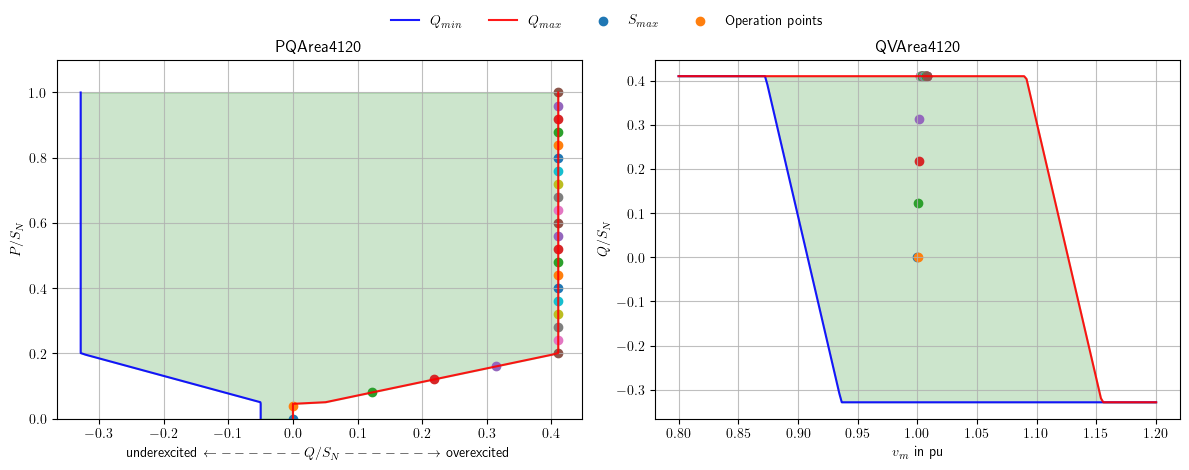

In [4]:
net = simple_test_net(p_vals)

# define PQV area, Q model and DERController
pqv_area = DERModels.PQVArea4120V2()
q_model = DERModels.QModelConstQ(q=0.5)
ctrl_sgen_new = pp.control.DERController(
    net, gid=net.sgen.index, q_model=q_model, pqv_area=pqv_area)

# run power flows and plot
pp.runpp(net, run_control=True)
plot_function(net, ctrl_sgen_new)

 ## Inverter apparent power limitation

According to the most recent VDE AR N standards, reactive power provision must be available even for full active power injection.
To, nevertheless, enable reducing power injection depending on maximum apparent power, such value can be passed as parameter `saturate_sn_mva` (default is NaN).
If `saturate_sn_mva` is not NaN, `q_prio` defines which power is reduced to achieve the apparent power limitation. In other cases, the parameter is inactive.

+ q_prio = True (default): DER active power is curtailed
+ q_prio = False: DER reactive power is curtailed


 Let's repeat the last calculation with `saturate_sn_mva=1.02` and `q_prio=True` to see the difference to the last results (again focus on the left plot): Due to the active power reduction, there are no dots with `p > sqrt(saturate_sn_mva^2 - q^2)`.
 Also note that, according to `PQVArea4120V2`, the plotted green area stays limited to `p_mw <= sn_mva` (sn_mva is used as installed active power generation), independed from given `saturate_sn_mva`.

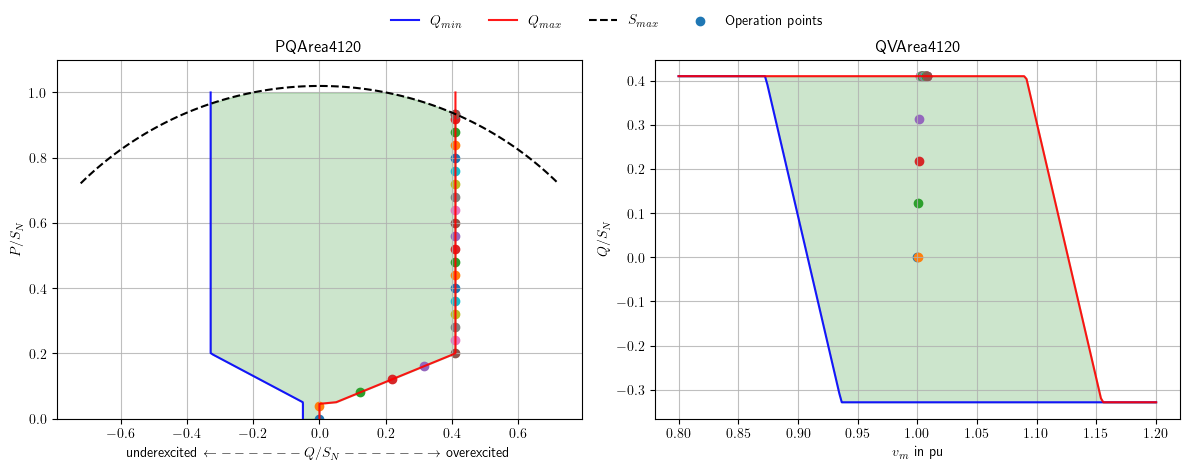

In [5]:
# change saturate_sn_mva using a new controller
net = simple_test_net(p_vals)

# define PQV area, Q model and DERController
pqv_area = DERModels.PQVArea4120V2()
q_model = DERModels.QModelConstQ(q=0.5)

ctrl_sgen_new = pp.control.DERController(
    net, gid=net.sgen.index, q_model=q_model, pqv_area=pqv_area, saturate_sn_mva=1.02, q_prio=True)

# run timeseries and plot results
pp.runpp(net, run_control=True)
plot_function(net, ctrl_sgen_new, saturate_sn_mva=1.02)


 If we consider `q_prio=False`, we can see in the left plot, that, for some operation points, q is reduced to zero to hold apparent power limits:

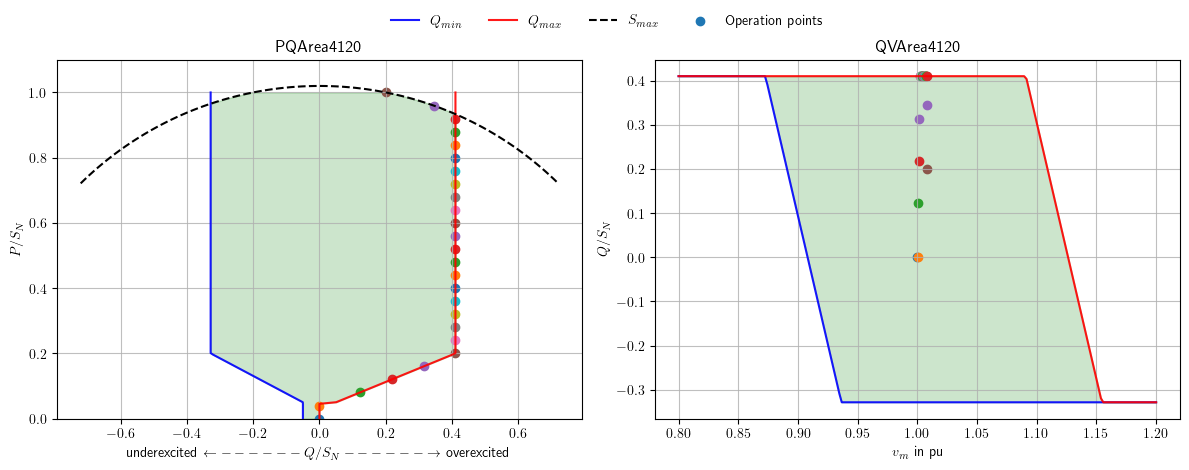

In [6]:
# change q_prio using a new controller
net = simple_test_net(p_vals)

# define PQV area, Q model and DERController
ctrl_sgen_new = pp.control.DERController(
    net, gid=net.sgen.index, q_model=DERModels.QModelConstQ(q=0.5),
    pqv_area=DERModels.PQVArea4120V2(), saturate_sn_mva=1.02, q_prio=False)

# run timeseries and plot results
pp.runpp(net, run_control=True)
plot_function(net, ctrl_sgen_new, saturate_sn_mva=1.02)


 ## Q(V) capability and voltage limitation function

 To visualize limiting the reactive power depending on the voltage of the RES connection point, we set the line length to 75 km. Then there is sufficient voltage rise to show that the controller reacts on over voltages via decreasing the inductive reactive power provision (overexcited behavior). That reduction is not used if the active power is low since then no overvoltages occur.

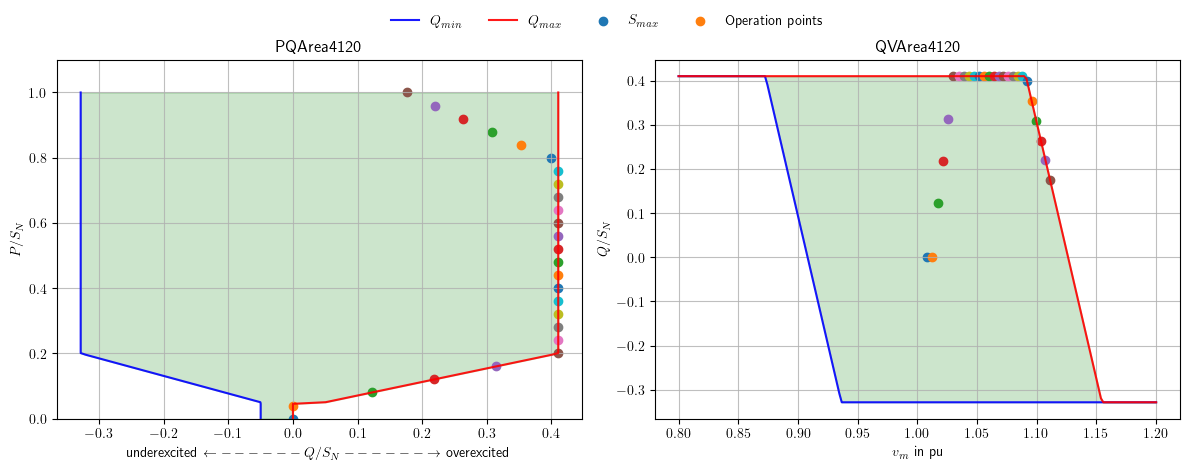

In [7]:
net = simple_test_net(p_vals)
# change line length to cause voltage issues
net.line["length_km"] = 70

# define PQV area, Q model and DERController
ctrl_sgen_new = pp.control.DERController(
    net, gid=net.sgen.index, q_model=DERModels.QModelConstQ(q=0.5),
    pqv_area=DERModels.PQVArea4120V2())

# run power flows and plot
pp.runpp(net, run_control=True)
plot_function(net, ctrl_sgen_new)


 To show that the PQ area, the QV area *and* the `saturate_sn_mva` parameter are considered simultaneously, we set a value to `saturate_sn_mva` that is below the highest apparent power reached:

In [8]:
s_sgen = pd.Series((net.res_sgen.p_mw**2 + net.res_sgen.q_mvar**2)**0.5, name="s_mva")
print(pd.concat([net.res_sgen, s_sgen], axis=1).iloc[-3:])

    p_mw    q_mvar     s_mva
23  0.92  0.263876  0.957095
24  0.96  0.219792  0.984839
25  1.00  0.176213  1.015407


In [9]:
assert s_sgen.max() > 1.01  # -> saturate_sn_mva=1.01 MVA will be relevant

net_saturated = deepcopy(net)
net_saturated.controller.object.iat[0].saturate_sn_mva = 1.01
pp.runpp(net_saturated, run_control=True)

s_sgen_saturated = pd.Series((net_saturated.res_sgen.p_mw**2 + net_saturated.res_sgen.q_mvar**2)**0.5, name="s_mva")
assert np.isclose(s_sgen.max(), 1.01, atol=1e-5)
print(pd.concat([net_saturated.res_sgen, s_sgen_saturated], axis=1).iloc[-3:])

        p_mw    q_mvar     s_mva
23  0.920000  0.263880  0.957096
24  0.960000  0.219795  0.984840
25  0.993169  0.183618  1.010000


 ## Modeling reactive power characteristics
 Among a static reactive power provision, as previously used in the tutorial (`q=0.5`), there are more advanced and grid-supporting reactive power behaviors.

 ### Cosphi(P) curve
 Because active power feed-in leads to a voltage increase, an `cosphi(P)` characteristic is applied by some distributed energy resources (DERs) to counteract the voltage rise by underexcited reactive power behavior, as exemplified in the following.

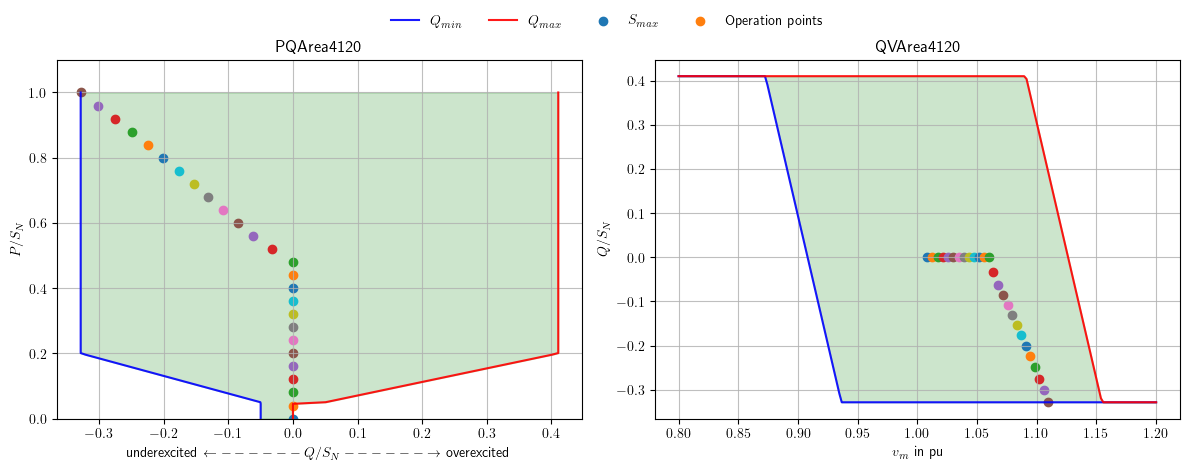

In [12]:
net_cosphiP = simple_test_net(p_vals)
net_cosphiP.line["length_km"] = 70

# define PQV area, Q model and DERController
q_model=DERModels.QModelCosphiPCurve(cosphi_p_curve={
        'p_points':(0, 0.5, 1), 'cosphi_points':(1, 1, -0.95)})

ctrl_sgen_new = pp.control.DERController(
    net_cosphiP, gid=net_cosphiP.sgen.index, q_model=q_model, pqv_area=DERModels.PQVArea4120V2())

# run power flows and plot
pp.runpp(net_cosphiP, run_control=True)
plot_function(net_cosphiP, ctrl_sgen_new)


In [13]:
greater_0_5 = net.sgen.index[net.sgen.p_mw > 0.5]
df_compare = pd.DataFrame({
    "Vm_qfix": net.res_bus.vm_pu.loc[net.sgen.bus.loc[greater_0_5]].values,
    "Vm_cosphiP": net_cosphiP.res_bus.vm_pu.loc[net_cosphiP.sgen.bus.loc[greater_0_5]].values,
    "P_qfix": net.res_sgen.p_mw.loc[greater_0_5],
    "P_cosphiP": net_cosphiP.res_sgen.p_mw.loc[greater_0_5],
    "Q_qfix": net.res_sgen.q_mvar.loc[greater_0_5],
    "Q_cosphiP": net.res_sgen.q_mvar.loc[greater_0_5],
})
print(df_compare)

     Vm_qfix  Vm_cosphiP  P_qfix  P_cosphiP    Q_qfix  Q_cosphiP
13  1.063974    1.063749    0.52       0.52  0.410769   0.410769
14  1.068044    1.067725    0.56       0.56  0.410769   0.410769
15  1.072085    1.071681    0.60       0.60  0.410769   0.410769
16  1.076098    1.075608    0.64       0.64  0.410769   0.410769
17  1.080082    1.079502    0.68       0.68  0.410769   0.410769
18  1.084039    1.083365    0.72       0.72  0.410769   0.410769
19  1.087969    1.087194    0.76       0.76  0.410769   0.410769
20  1.091890    1.090990    0.80       0.80  0.399366   0.399366
21  1.095825    1.094754    0.84       0.84  0.353641   0.353641
22  1.099712    1.098484    0.88       0.88  0.308485   0.308485
23  1.103551    1.102182    0.92       0.92  0.263876   0.263876
24  1.107344    1.105847    0.96       0.96  0.219792   0.219792
25  1.111095    1.109479    1.00       1.00  0.176213   0.176213


 ### Cosphi(P)
 ## "explination TODO"

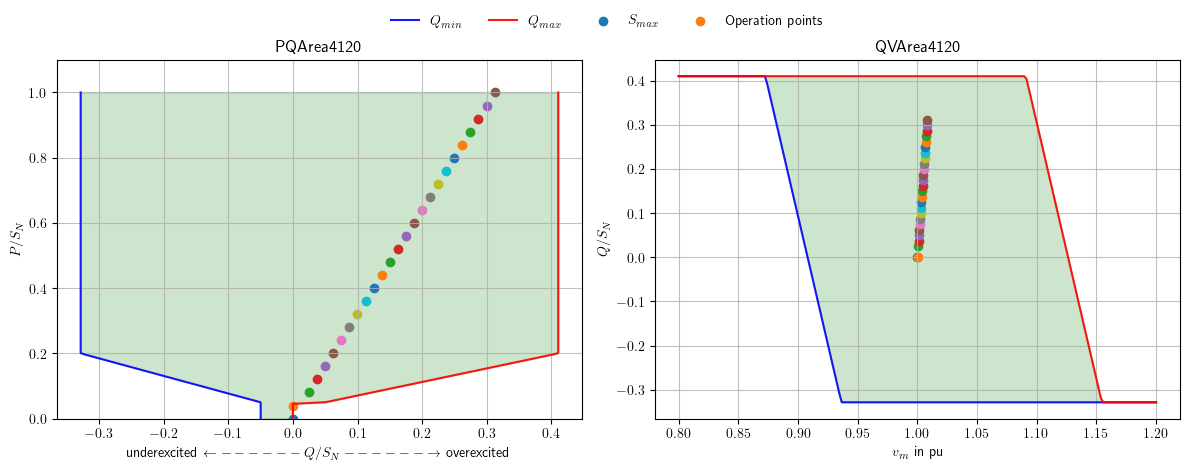

In [11]:
net = simple_test_net(p_vals)

# define PQV area, Q model and DERController
q_model = DERModels.QModelCosphiP(cosphi=0.95)

ctrl_sgen_new = pp.control.DERController(
    net, gid=net.sgen.index, q_model=q_model, pqv_area=DERModels.PQVArea4120V2())

# run power flows and plot
pp.runpp(net, run_control=True)
plot_function(net, ctrl_sgen_new)


 ### Q(V) curve
 ## "explination TODO"

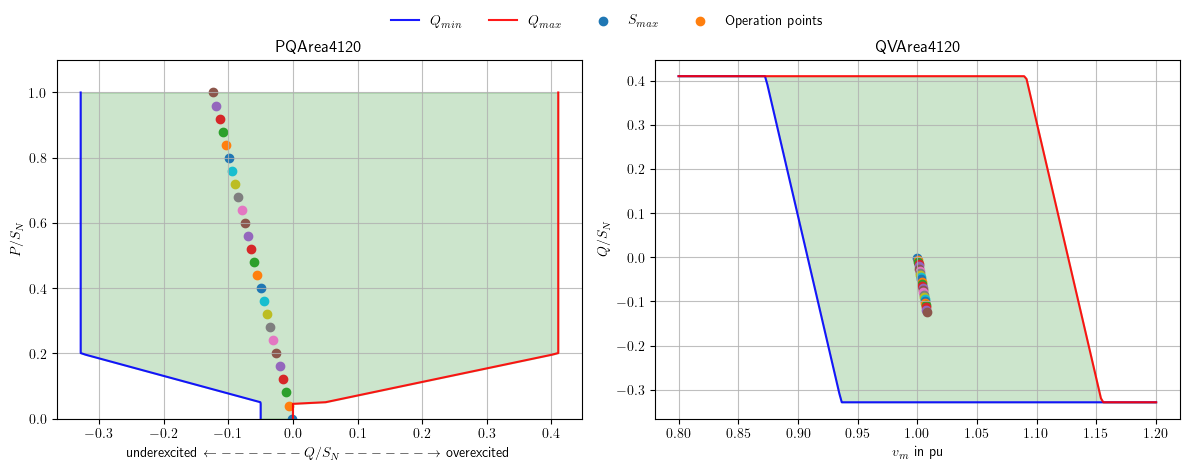

In [12]:
net = simple_test_net(p_vals)

# define PQV area, Q model and DERController
q_model = DERModels.QModelQV(qv_curve=DERModels.QVCurve(
    v_points_pu=(0, 0.90, 1.00, 1.02, 2),
    q_points=(0.312, 0.312, 0, -0.312, -0.312)))

ctrl_sgen_new = pp.control.DERController(
    net, gid=net.sgen.index, q_model=q_model, pqv_area=DERModels.PQVArea4120V2())

# run power flows and plot
pp.runpp(net, run_control=True)
plot_function(net, ctrl_sgen_new)


Multiple active power injection states can also be analyzed performing a timeseries calculation of one controller sgen. This is applied here for demonstration reasons. Furthermore, negative active power values are assumed in the timeseries data to show the functionality of profile_sacle.

In [13]:
def simple_test_net_for_timeseries():
    # this is basically the same grid as simple_test_net() but with only one line to one bus
    # with one sgen
    net = pp.create_empty_network()
    pp.create_buses(net, 2, vn_kv=20)
    pp.create_ext_grid(net, 0)
    pp.create_sgen(net, 1, p_mw=1., sn_mva=1.)
    pp.create_line(net, 0, 1, length_km=5.0, std_type="NAYY 4x50 SE")

    # create outputwriter and define variables to log
    ow = pp.timeseries.OutputWriter(net)
    ow.log_variable("res_sgen", "p_mw")
    ow.log_variable("res_sgen", "q_mvar")

    return net, ow

ts_data = pd.DataFrame({"p_0": -p_vals})
data = pp.timeseries.DFData(ts_data)

 ### Statcom capability
 Statcom capability does not depend on active power P, it can provide reactive power Q without active power.
 `min_q` and `max_q` are reactive power limits, adjustable and user defined parameters.

100%|██████████| 26/26 [00:02<00:00, 11.29it/s]


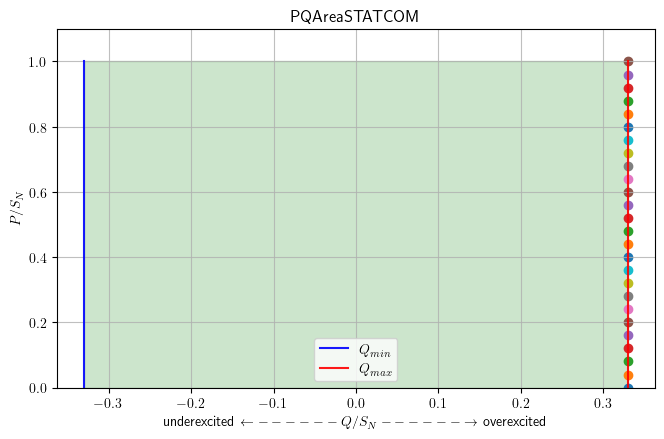

In [14]:
net, ow = simple_test_net_for_timeseries()

# define PQV area, Q model and DERController
pq_area = DERModels.PQAreaSTATCOM(min_q=-0.33, max_q=0.33)

ctrl_sgen_new = pp.control.DERController(
    net, gid=0, q_model=DERModels.QModelConstQ(q=0.5),
    pqv_area=pq_area,
    data_source=data, p_profile="p_0", profile_scale=-1)

# run power flows and plot
pp.timeseries.run_timeseries(net, time_steps=range(len(p_vals)))
plot_function(net, pq_area=pq_area, ow=ow)
